In [2]:
pip install transformers datasets torch scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 824.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('./drive/MyDrive/ColabNotebooks/semeval_project/train_data.csv')

# Split dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['clean_text'],
    data[['anger', 'fear', 'joy', 'sadness', 'surprise']].values,
    test_size=0.2,
    random_state=42
)


In [ ]:
from transformers import AutoTokenizer

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('j-hartmann/emotion-english-distilroberta-base')

#tokenizer = AutoTokenizer.from_pretrained('bhadresh-savani/distilbert-base-uncased-emotion')

# Tokenize text
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [ ]:
import torch

class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

# Create dataset objects
train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)


In [ ]:
from transformers import AutoModelForSequenceClassification

# Load model with 5 output labels for multi-label classification
model = AutoModelForSequenceClassification.from_pretrained(
    'j-hartmann/emotion-english-distilroberta-base',
    num_labels=5,
    problem_type="multi_label_classification",
    ignore_mismatched_sizes=True
)


pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch.utils.data import DataLoader
from transformers import AdamW
from transformers import get_scheduler

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * 3  # 3 epochs
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from torch.nn import BCEWithLogitsLoss
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score
import torch

# Use GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Save model checkpoint (NEW)
checkpoint_path = "./drive/MyDrive/ColabNotebooks/semeval_project/model_checkpoint.pth"

# Training loop
def train_epoch(model, train_loader):
    model.train()
    loss_fn = BCEWithLogitsLoss()
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = loss_fn(outputs.logits, batch['labels'])
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

# Function to save model checkpoint (NEW)
def save_checkpoint(model, optimizer, epoch, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, path)

# Function to load model checkpoint (NEW)
def load_checkpoint(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch']

# Evaluation function
def evaluate(model, val_loader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss_fn = BCEWithLogitsLoss()
            total_loss += loss_fn(outputs.logits, batch['labels']).item()

            # Collect predictions and true labels
            logits = torch.sigmoid(outputs.logits).cpu().numpy()
            preds = (logits > 0.5).astype(int)  # Threshold for multi-label classification
            all_preds.extend(preds)
            all_labels.extend(batch['labels'].cpu().numpy())

    # Calculate metrics
    all_preds = torch.tensor(all_preds).cpu()  # Move all_preds to cpu before converting to NumPy
    all_labels = torch.tensor(all_labels).cpu()  # Move all_labels to cpu before converting to NumPy
    accuracy = accuracy_score(all_labels.numpy(), all_preds.numpy())  # Convert to NumPy arrays
    f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average='weighted')  # Convert to NumPy arrays

    return total_loss / len(val_loader), accuracy, f1

# File to store metrics
metrics_file = "./drive/MyDrive/ColabNotebooks/semeval_project/metrics_log.txt"
with open(metrics_file, 'w') as f:
    f.write("Epoch\tValidation_Loss\tAccuracy\tF1_Score\n")

# Training loop with checkpointing and metrics logging
epochs = 5
start_epoch = 0
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)  # Initialize optimizer (NEW)

# Load checkpoint if exists (NEW)
try:
    start_epoch = load_checkpoint(model, optimizer, checkpoint_path)
    print(f"Resuming training from epoch {start_epoch + 1}")
except FileNotFoundError:
    print("No checkpoint found, starting training from scratch.")

for epoch in range(start_epoch, epochs):
    train_epoch(model, train_loader)
    val_loss, accuracy, f1 = evaluate(model, val_loader)

    # Log metrics
    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss}, Accuracy: {accuracy}, F1 Score: {f1}')
    with open(metrics_file, 'a') as f:
        f.write(f"{epoch + 1}\t{val_loss:.4f}\t{accuracy:.4f}\t{f1:.4f}\n")

    # Save checkpoint after each epoch (NEW)
    save_checkpoint(model, optimizer, epoch, checkpoint_path)


<ipython-input-8-640987d12bda>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


No checkpoint found, starting training from scratch.


<ipython-input-8-640987d12bda>:62: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  all_preds = torch.tensor(all_preds).cpu()  # Move all_preds to cpu before converting to NumPy


Epoch 1, Validation Loss: 0.3985580195273672, Accuracy: 0.38148984198645597, F1 Score: 0.6695689304365707
Epoch 2, Validation Loss: 0.38716924829142435, Accuracy: 0.417607223476298, F1 Score: 0.7060104770280908
Epoch 3, Validation Loss: 0.4185387263340609, Accuracy: 0.40632054176072235, F1 Score: 0.704935332512834
Epoch 4, Validation Loss: 0.4390034611736025, Accuracy: 0.4108352144469526, F1 Score: 0.7114883324340684
Epoch 5, Validation Loss: 0.48864017320530756, Accuracy: 0.44243792325056436, F1 Score: 0.7099062474529031


In [ ]:
from torch.nn import BCEWithLogitsLoss
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score

# Use GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Training loop
def train_epoch(model, train_loader):
    model.train()
    loss_fn = BCEWithLogitsLoss()
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = loss_fn(outputs.logits, batch['labels'])
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

def evaluate(model, val_loader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss_fn = BCEWithLogitsLoss()
            total_loss += loss_fn(outputs.logits, batch['labels']).item()

            # Collect predictions and true labels
            logits = torch.sigmoid(outputs.logits).cpu().numpy()
            preds = (logits > 0.5).astype(int)  # Threshold for multi-label classification
            all_preds.extend(preds)
            all_labels.extend(batch['labels'].cpu().numpy())

      # Calculate metrics
        all_preds = torch.tensor(all_preds).cpu() # Move all_preds to cpu before converting to NumPy
        all_labels = torch.tensor(all_labels).cpu() # Move all_labels to cpu before converting to NumPy
        accuracy = accuracy_score(all_labels.numpy(), all_preds.numpy()) # convert to NumPy arrays before passing to accuracy_score
        f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average='weighted') # convert to NumPy arrays before passing to f1_score

    return total_loss / len(val_loader), accuracy, f1

# File to store metrics
metrics_file = "./drive/MyDrive/ColabNotebooks/semeval_project/metrics_log.txt"
with open(metrics_file, 'w') as f:
    f.write("Epoch\tValidation_Loss\tAccuracy\tF1_Score\n")

# Training loop with metrics logging
epochs = 2
for epoch in range(epochs):
    train_epoch(model, train_loader)
    val_loss, accuracy, f1 = evaluate(model, val_loader)

    # Log metrics
    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss}, Accuracy: {accuracy}, F1 Score: {f1}')
    with open(metrics_file, 'a') as f:
        f.write(f"{epoch + 1}\t{val_loss:.4f}\t{accuracy:.4f}\t{f1:.4f}\n")


Epoch 1, Validation Loss: 0.3953494940485273, Accuracy: 0.417607223476298, F1 Score: 0.7019994992316219
Epoch 2, Validation Loss: 0.3953494940485273, Accuracy: 0.417607223476298, F1 Score: 0.7019994992316219


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Assuming 'tokenizer' and 'model' are already fine-tuned objects
save_dir = './drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_pretrained'

# Save both tokenizer and model properly
tokenizer.save_pretrained(save_dir)
model.save_pretrained(save_dir)

In [ ]:
# Save the new model
model.save_pretrained('./drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_pretrained')
tokenizer.save_pretrained('./drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_pretrained')


('./drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_pretrained/tokenizer_config.json',
 './drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_pretrained/special_tokens_map.json',
 './drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_pretrained/vocab.json',
 './drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_pretrained/merges.txt',
 './drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_pretrained/added_tokens.json',
 './drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_pretrained/tokenizer.json')

In [ ]:
#Testing the results
from transformers import pipeline

# Load the model and tokenizer
emotion_model = pipeline('text-classification', model='emotion_model_pretrained', tokenizer='emotion_model_pretrained', return_all_scores=True)

# Predict
text = "I feel so happy today!"
predictions = emotion_model(text)
print(predictions)


Device set to use cpu


[[{'label': 'LABEL_0', 'score': 0.061129894107580185}, {'label': 'LABEL_1', 'score': 0.04180305823683739}, {'label': 'LABEL_2', 'score': 0.9680857062339783}, {'label': 'LABEL_3', 'score': 0.07458458840847015}, {'label': 'LABEL_4', 'score': 0.1456994116306305}]]


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [29]:
# Load the model for inference
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("./drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_pretrained")

In [32]:
# Inference
def predict_emotions(text, model, tokenizer, device):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(inputs['input_ids'], inputs['attention_mask'])
        probs = torch.sigmoid(outputs.logits).cpu().numpy() # Apply sigmoid to outputs.logits
    return probs > 0.5

text = "Despite feeling overwhelmed by the relentless pressure at work, I maintain a facade of calm, though beneath the surface, anxiety and frustration often bubble up, making me question how long I can keep pretending."
predicted_emotions = predict_emotions(text, model, tokenizer, device)
print("Predicted Emotions:", predicted_emotions)

Predicted Emotions: [[False  True False False  True]]


In [33]:
# To see the output in emotion name format
def predict_emotions_with_details(text, model, tokenizer, emotion_labels, device):
    """
    Predict emotions for a given text with details.
    Returns the predicted emotions, binary outputs, and probabilities.
    """
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

    # Remove token_type_ids if not required by the model
    if "token_type_ids" in inputs:
        del inputs["token_type_ids"]

    with torch.no_grad():
        outputs = model(**inputs)  # Use model inputs
        logits = outputs.logits if hasattr(outputs, "logits") else outputs  # Handle plain tensor outputs
        probs = torch.sigmoid(logits).cpu().numpy()[0]  # Convert logits to probabilities

    # Determine binary outputs (True/False) based on a threshold
    binary_outputs = probs > 0.5

    # Map True/False to emotion labels
    predicted_emotion = [emotion for emotion, binary in zip(emotion_labels, binary_outputs) if binary]

    return predicted_emotion, binary_outputs, probs


In [35]:
# One by one model testing
text = "Despite feeling overwhelmed by the relentless pressure at work, I maintain a facade of calm, though beneath the surface, anxiety and frustration often bubble up, making me question how long I can keep pretending."
emotion_labels = ["anger", "fear", "joy", "sadness", "surprise"]

predicted_emotion, binary_outputs, probabilities = predict_emotions_with_details(
    text, model, tokenizer, emotion_labels, device
)

print("Predicted Emotion(s):", predicted_emotion)
print("Binary Outputs (True/False):", binary_outputs)
print("Probabilities:", probabilities)

Predicted Emotion(s): ['fear', 'surprise']
Binary Outputs (True/False): [False  True False False  True]
Probabilities: [0.00821886 0.99756795 0.00932841 0.24750209 0.66594476]


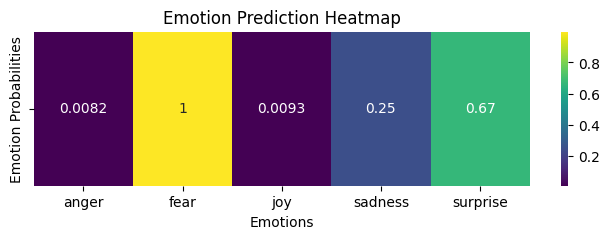

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Sample input (Replace with actual output from your function)
emotion_labels = ["anger", "fear", "joy", "sadness", "surprise"]
probabilities = np.array(probabilities)  # Convert to NumPy array if needed

# Create a heatmap
plt.figure(figsize=(8, 2))
sns.heatmap([probabilities], annot=True, cmap="viridis", xticklabels=emotion_labels, yticklabels=["Emotion Probabilities"])

# Formatting
plt.title("Emotion Prediction Heatmap")
plt.xlabel("Emotions")
plt.ylabel("")
plt.savefig('emotion_heatmap_BERT.png')
plt.show()


Fine Tuning with RoBERta

In [ ]:
# load the required packages
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_scheduler
from sklearn.metrics import accuracy_score, f1_score
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader
import torch

In [ ]:
######new try####### # Specify the pre-trained Hugging Face model name
model_name = "bhadresh-savani/distilbert-base-uncased-emotion"  # Example: 'bert-base-uncased'

# Load the pre-trained model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5, problem_type="multi_label_classification", ignore_mismatched_sizes=True)

# Prepare dataset (assuming it's already tokenized and split as before)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

# Optimizer with modified learning rate for fine-tuning
optimizer = AdamW(model.parameters(), lr=2e-5)  # Adjust the learning rate for fine-tuning

# Learning rate scheduler
num_training_steps = len(train_loader) * 3  # 3 fine-tuning epochs
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at bhadresh-savani/distilbert-base-uncased-emotion and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([6]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([6, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
import os

model_path = './drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_pretrained'
print(os.listdir(model_path))

['model.safetensors', 'tokenizer_config.json', 'special_tokens_map.json', 'vocab.json', 'merges.txt', 'tokenizer.json', 'config.json']


In [ ]:
# Load the previously fine-tuned model and tokenizer
model_path = './drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_pretrained'  # Path where the initial fine-tuned model is saved
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Prepare dataset (assuming it's already tokenized and split as before)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [ ]:
# Optimizer with modified learning rate for fine-tuning
optimizer = AdamW(model.parameters(), lr=5e-5)  # Adjust the learning rate for fine-tuning

# Learning rate scheduler
num_training_steps = len(train_loader) * 3  # 3 fine-tuning epochs
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Use GPU if available
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
           

In [ ]:
# Training loop
def train_epoch(model, train_loader):
    model.train()
    loss_fn = BCEWithLogitsLoss()
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = loss_fn(outputs.logits, batch['labels'])
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

def evaluate(model, val_loader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss_fn = BCEWithLogitsLoss()
            total_loss += loss_fn(outputs.logits, batch['labels']).item()

            logits = torch.sigmoid(outputs.logits).cpu().numpy()
            preds = (logits > 0.5).astype(int)
            all_preds.extend(preds)
            all_labels.extend(batch['labels'].cpu().numpy())

        all_preds = torch.tensor(all_preds).cpu()
        all_labels = torch.tensor(all_labels).cpu()

        # Convert tensors to NumPy arrays before using with scikit-learn
        accuracy = accuracy_score(all_labels.numpy(), all_preds.numpy())
        f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average='weighted')

    return total_loss / len(val_loader), accuracy, f1

# Fine-tuning loop
metrics_file = "./drive/MyDrive/ColabNotebooks/semeval_project/metrics_fine_tuned.txt"
with open(metrics_file, 'w') as f:
    f.write("Epoch\tValidation_Loss\tAccuracy\tF1_Score\n")

epochs = 5  # Fine-tuning for additional 3 epochs
for epoch in range(epochs):
    train_epoch(model, train_loader)
    val_loss, accuracy, f1 = evaluate(model, val_loader)
    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss}, Accuracy: {accuracy}, F1 Score: {f1}')
    with open(metrics_file, 'a') as f:
        f.write(f"{epoch + 1}\t{val_loss:.4f}\t{accuracy:.4f}\t{f1:.4f}\n")

# Save the fine-tuned model
model.save_pretrained('./drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_fine_tuned')
tokenizer.save_pretrained('./drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_fine_tuned')

Epoch 1, Validation Loss: 0.5353031179734639, Accuracy: 0.38826185101580135, F1 Score: 0.6878588703472901
Epoch 2, Validation Loss: 0.5452573150396347, Accuracy: 0.40857787810383744, F1 Score: 0.7213220809326109
Epoch 3, Validation Loss: 0.5549502606902804, Accuracy: 0.42663656884875845, F1 Score: 0.716522940519222
Epoch 4, Validation Loss: 0.5549502606902804, Accuracy: 0.42663656884875845, F1 Score: 0.716522940519222
Epoch 5, Validation Loss: 0.5549502606902804, Accuracy: 0.42663656884875845, F1 Score: 0.716522940519222


('./drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_fine_tuned/tokenizer_config.json',
 './drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_fine_tuned/special_tokens_map.json',
 './drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_fine_tuned/vocab.json',
 './drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_fine_tuned/merges.txt',
 './drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_fine_tuned/added_tokens.json',
 './drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_fine_tuned/tokenizer.json')

('emotion_model_fine_tuned/tokenizer_config.json',
 'emotion_model_fine_tuned/special_tokens_map.json',
 'emotion_model_fine_tuned/vocab.json',
 'emotion_model_fine_tuned/merges.txt',
 'emotion_model_fine_tuned/added_tokens.json',
 'emotion_model_fine_tuned/tokenizer.json')

RoBERTa  model testing and result

In [ ]:
# Load the model for inference
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("./drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_fine_tuned")

# Inference
def predict_emotions(text, model, tokenizer, device):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(inputs['input_ids'], inputs['attention_mask'])
        probs = torch.sigmoid(outputs.logits).cpu().numpy() # Apply sigmoid to outputs.logits
    return probs > 0.5

text = "After standing in a few times in the past his buddy asks again but warns him that it is the full moon and it won't be like the last times."
predicted_emotions = predict_emotions(text, model, tokenizer, device)
print("Predicted Emotions:", predicted_emotions)

Predicted Emotions: [[False  True False  True  True]]


In [ ]:
# To see the output in emotion name format
def predict_emotions_with_details(text, model, tokenizer, emotion_labels, device):
    """
    Predict emotions for a given text with details.
    Returns the predicted emotions, binary outputs, and probabilities.
    """
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

    # Remove token_type_ids if not required by the model
    if "token_type_ids" in inputs:
        del inputs["token_type_ids"]

    with torch.no_grad():
        outputs = model(**inputs)  # Use model inputs
        logits = outputs.logits if hasattr(outputs, "logits") else outputs  # Handle plain tensor outputs
        probs = torch.sigmoid(logits).cpu().numpy()[0]  # Convert logits to probabilities

    # Determine binary outputs (True/False) based on a threshold
    binary_outputs = probs > 0.5

    # Map True/False to emotion labels
    predicted_emotion = [emotion for emotion, binary in zip(emotion_labels, binary_outputs) if binary]

    return predicted_emotion, binary_outputs, probs

In [ ]:
# One by one model testing
text = "After standing in a few times in the past his buddy asks again but warns him that it is the full moon and it won't be like the last times."
emotion_labels = ["anger", "fear", "joy", "sadness", "surprise"]

predicted_emotion, binary_outputs, probabilities = predict_emotions_with_details(
    text, model, tokenizer, emotion_labels, device
)

print("Predicted Emotion(s):", predicted_emotion)
print("Binary Outputs (True/False):", binary_outputs)
print("Probabilities:", probabilities)

Predicted Emotion(s): ['fear', 'sadness', 'surprise']
Binary Outputs (True/False): [False  True False  True  True]
Probabilities: [0.00481134 0.99023086 0.00171604 0.86018056 0.9270706 ]


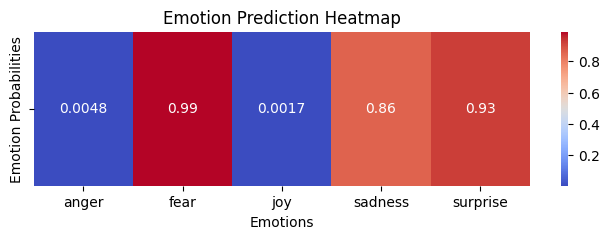

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Sample input (Replace with actual output from your function)
emotion_labels = ["anger", "fear", "joy", "sadness", "surprise"]
probabilities = np.array(probabilities)  # Convert to NumPy array if needed

# Create a heatmap
plt.figure(figsize=(8, 2))
sns.heatmap([probabilities], annot=True, cmap="coolwarm", xticklabels=emotion_labels, yticklabels=["Emotion Probabilities"])

# Formatting
plt.title("Emotion Prediction Heatmap")
plt.xlabel("Emotions")
plt.ylabel("")
plt.savefig('emotion_heatmap.png')
plt.show()


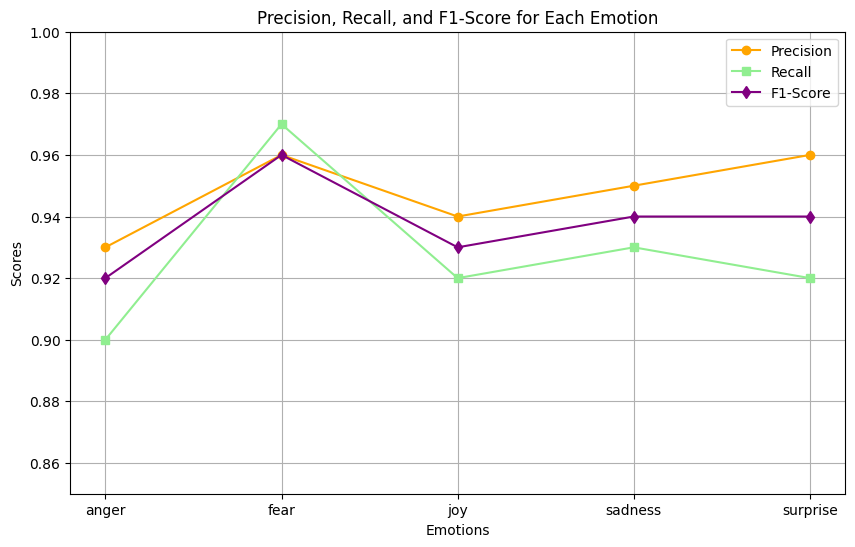

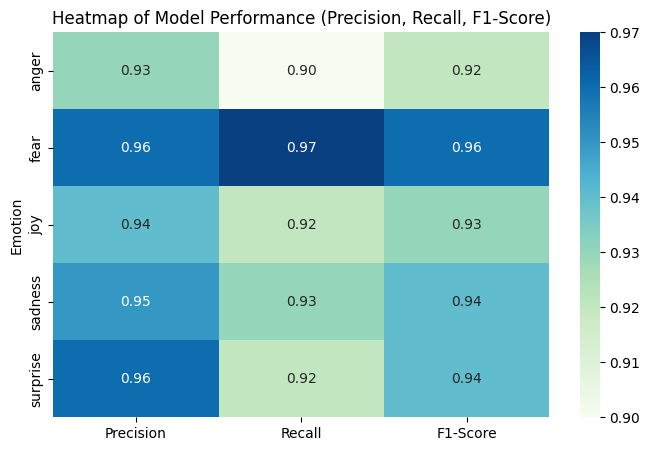

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Emotion labels and corresponding metrics from your classification report
emotion_labels = ["anger", "fear", "joy", "sadness", "surprise"]
precision = [0.93, 0.96, 0.94, 0.95, 0.96]
recall = [0.90, 0.97, 0.92, 0.93, 0.92]
f1_score = [0.92, 0.96, 0.93, 0.94, 0.94]

# Create DataFrame for better visualization
df = pd.DataFrame({
    "Emotion": emotion_labels,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1_score,
})

# Plot line graph for Precision, Recall, and F1-score
plt.figure(figsize=(10, 6))
plt.plot(emotion_labels, precision, marker='o', linestyle='-', color='orange', label='Precision')
plt.plot(emotion_labels, recall, marker='s', linestyle='-', color='lightgreen', label='Recall')
plt.plot(emotion_labels, f1_score, marker='d', linestyle='-', color='purple', label='F1-Score')

plt.xlabel("Emotions")
plt.ylabel("Scores")
plt.title("Precision, Recall, and F1-Score for Each Emotion")
plt.legend()
plt.ylim(0.85, 1.0)  # Adjust y-axis for better clarity
plt.grid(True)  # Add grid for better readability
plt.savefig('emotion_line_graph_precision_recall_F1.png')
plt.show()

# Create a heatmap for better visualization
plt.figure(figsize=(8, 5))
sns.heatmap(df.set_index("Emotion"), annot=True, cmap="GnBu", fmt=".2f")
plt.title("Heatmap of Model Performance (Precision, Recall, F1-Score)")
plt.savefig('emotion_heatmap_precision_recall_F1.png')
plt.show()


Model testing and comparision with Manually tested dataset

Classification Report:

              precision    recall  f1-score   support

       anger       0.93      0.90      0.92       264
        fear       0.96      0.97      0.96      1295
         joy       0.94      0.92      0.93       538
     sadness       0.95      0.93      0.94       709
    surprise       0.96      0.92      0.94       670

   micro avg       0.95      0.94      0.94      3476
   macro avg       0.95      0.93      0.94      3476
weighted avg       0.95      0.94      0.94      3476
 samples avg       0.87      0.86      0.86      3476



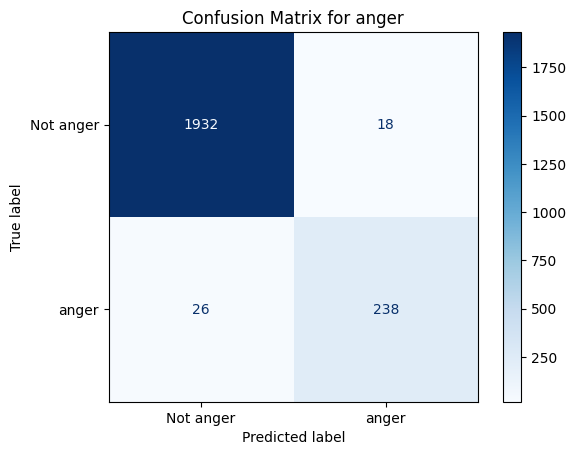

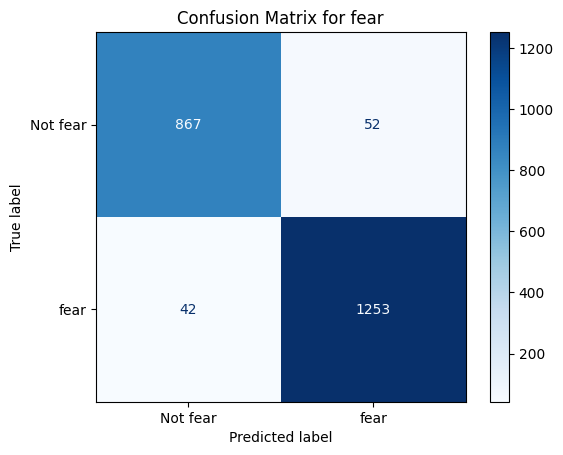

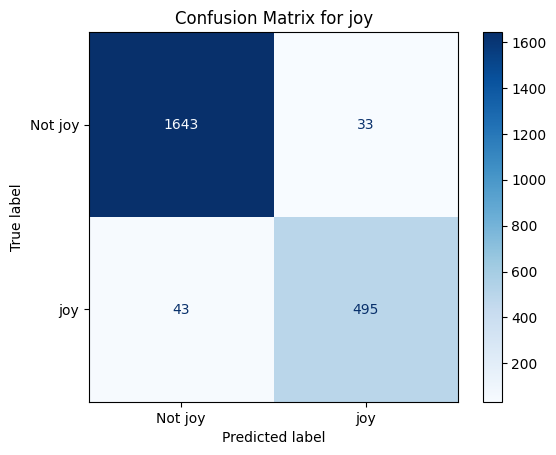

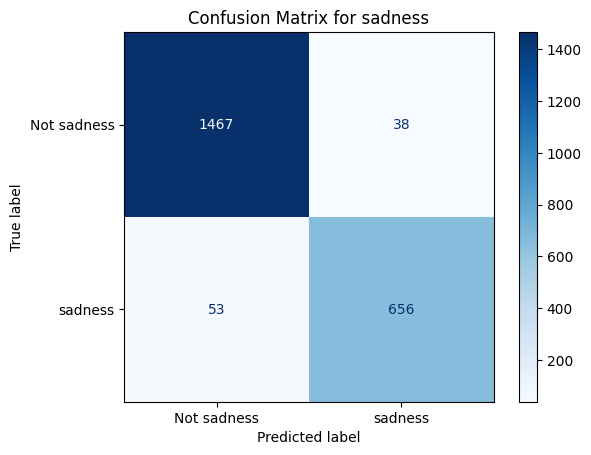

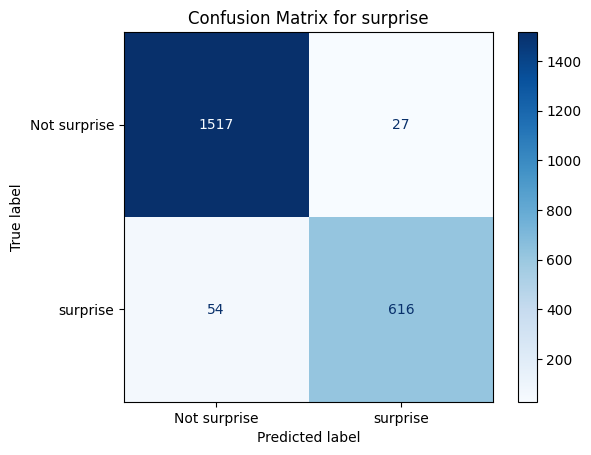

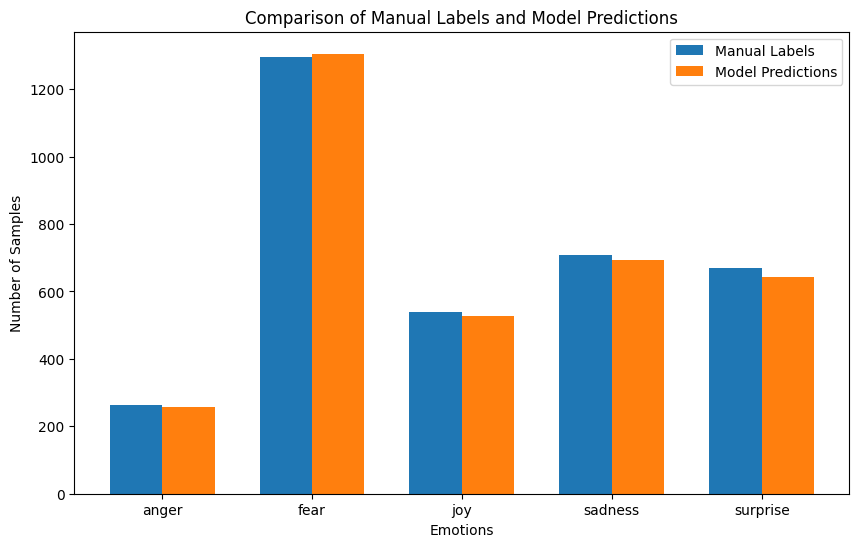

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Load the fine-tuned model and tokenizer
model_path = './drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_fine_tuned'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Prepare test data
test_texts = data['clean_text']  # Assuming 'data' contains your full dataset
manual_labels = data[['anger', 'fear', 'joy', 'sadness', 'surprise']].values  # Manually labeled emotions

# Tokenize test texts
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128, return_tensors="pt")
test_encodings = {key: val.to(device) for key, val in test_encodings.items()}

# Get predictions
model.eval()
with torch.no_grad():
    outputs = model(**test_encodings)
    logits = torch.sigmoid(outputs.logits)  # Convert logits to probabilities
    predictions = (logits.cpu().numpy() > 0.5).astype(int)  # Binary predictions (threshold = 0.5)

# Generate classification report
print("Classification Report:\n")
print(classification_report(manual_labels, predictions, target_names=['anger', 'fear', 'joy', 'sadness', 'surprise'], zero_division=0))

# Calculate confusion matrix for each label
for i, emotion in enumerate(['anger', 'fear', 'joy', 'sadness', 'surprise']):
    cm = confusion_matrix(manual_labels[:, i], predictions[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Not {emotion}", emotion])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {emotion}")
    plt.show()

# Graph: Compare manual vs model predictions
manual_totals = np.sum(manual_labels, axis=0)
predicted_totals = np.sum(predictions, axis=0)

x = np.arange(len(['anger', 'fear', 'joy', 'sadness', 'surprise']))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width / 2, manual_totals, width, label='Manual Labels')
plt.bar(x + width / 2, predicted_totals, width, label='Model Predictions')

plt.xticks(x, ['anger', 'fear', 'joy', 'sadness', 'surprise'])
plt.xlabel('Emotions')
plt.ylabel('Number of Samples')
plt.title('Comparison of Manual Labels and Model Predictions')
plt.legend()
plt.show()


# Adjustements with the pos_weight

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader
from torch.nn import BCEWithLogitsLoss
import numpy as np

#  Step 1: Load the Fine-Tuned RoBERTa Model
model_path = './drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_fine_tuned'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
           

In [6]:
#  Step 2: Calculate pos_weight for each class
emotions = ['anger', 'fear', 'joy', 'sadness', 'surprise']
pos_weights = []

for emotion in emotions:
    pos_count = data[emotion].sum()  # Number of positive examples
    neg_count = len(data) - pos_count  # Number of negative examples
    pos_weights.append(neg_count / pos_count)

pos_weights_tensor = torch.tensor(pos_weights, dtype=torch.float32).to(device)

In [7]:
#  Step 3: Define the loss function with adjusted weights
criterion = BCEWithLogitsLoss(pos_weight=pos_weights_tensor)

# Step 4: Prepare the dataset
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [8]:
#  Step 5: Define Training and Evaluation Functions
def train_epoch(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = criterion(outputs.logits, batch['labels'])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = criterion(outputs.logits, batch['labels'])
            total_loss += loss.item()

            logits = torch.sigmoid(outputs.logits).cpu().numpy()
            preds = (logits > 0.5).astype(int)
            all_preds.extend(preds)
            all_labels.extend(batch['labels'].cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return total_loss / len(val_loader), accuracy, f1

In [9]:
#  Step 6: Fine-Tuning the Model with Adjusted Weights
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
epochs = 5

for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, accuracy, f1 = evaluate(model, val_loader, criterion)
    print(f"Epoch {epoch + 1}: Train Loss = {train_loss}, Val Loss = {val_loss}, Accuracy = {accuracy}, F1 Score = {f1}")

#  Step 7: Save the Adjusted Model
model.save_pretrained('./drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_adjusted')
tokenizer.save_pretrained('./drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_adjusted')

Epoch 1: Train Loss = 0.05181723348125144, Val Loss = 1.112527227827481, Accuracy = 0.39954853273137697, F1 Score = 0.7092924133090802
Epoch 2: Train Loss = 0.04144866975980836, Val Loss = 1.2560569675905364, Accuracy = 0.41309255079006774, F1 Score = 0.7111361964058733
Epoch 3: Train Loss = 0.030600000810515775, Val Loss = 1.139796409223761, Accuracy = 0.38826185101580135, F1 Score = 0.7158898315662523
Epoch 4: Train Loss = 0.033397705344533596, Val Loss = 1.2468481383153371, Accuracy = 0.4018058690744921, F1 Score = 0.7158258070680974
Epoch 5: Train Loss = 0.02265027999827588, Val Loss = 1.2492337567465646, Accuracy = 0.4018058690744921, F1 Score = 0.725983075907103


('./drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_adjusted/tokenizer_config.json',
 './drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_adjusted/special_tokens_map.json',
 './drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_adjusted/vocab.json',
 './drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_adjusted/merges.txt',
 './drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_adjusted/added_tokens.json',
 './drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_adjusted/tokenizer.json')

model testing for weight adjusted dataset

In [8]:
# Load the model for inference
from transformers import AutoModelForSequenceClassification, AutoTokenizer
model = AutoModelForSequenceClassification.from_pretrained("./drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_adjusted")

# Load the tokenizer (same path as the model)
tokenizer = AutoTokenizer.from_pretrained("./drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_adjusted") # Load tokenizer

# Define device
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Inference
def predict_emotions(text, model, tokenizer, device):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(inputs['input_ids'], inputs['attention_mask'])
        probs = torch.sigmoid(outputs.logits).cpu().numpy() # Apply sigmoid to outputs.logits
    return probs > 0.5

text = "After standing in a few times in the past his buddy asks again but warns him that it is the full moon and it won't be like the last times."
predicted_emotions = predict_emotions(text, model, tokenizer, device)
print("Predicted Emotions:", predicted_emotions)

Predicted Emotions: [[False  True False  True  True]]


In [9]:
# To see the output in emotion name format
def predict_emotions_with_details(text, model, tokenizer, emotion_labels, device):
    """
    Predict emotions for a given text with details.
    Returns the predicted emotions, binary outputs, and probabilities.
    """
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

    # Remove token_type_ids if not required by the model
    if "token_type_ids" in inputs:
        del inputs["token_type_ids"]

    with torch.no_grad():
        outputs = model(**inputs)  # Use model inputs
        logits = outputs.logits if hasattr(outputs, "logits") else outputs  # Handle plain tensor outputs
        probs = torch.sigmoid(logits).cpu().numpy()[0]  # Convert logits to probabilities

    # Determine binary outputs (True/False) based on a threshold
    binary_outputs = probs > 0.5

    # Map True/False to emotion labels
    predicted_emotion = [emotion for emotion, binary in zip(emotion_labels, binary_outputs) if binary]

    return predicted_emotion, binary_outputs, probs

In [10]:
# One by one model testing
text = "After standing in a few times in the past his buddy asks again but warns him that it is the full moon and it won't be like the last times."
emotion_labels = ["anger", "fear", "joy", "sadness", "surprise"]

predicted_emotion, binary_outputs, probabilities = predict_emotions_with_details(
    text, model, tokenizer, emotion_labels, device
)

print("Predicted Emotion(s):", predicted_emotion)
print("Binary Outputs (True/False):", binary_outputs)
print("Probabilities:", probabilities)

Predicted Emotion(s): ['fear', 'sadness', 'surprise']
Binary Outputs (True/False): [False  True False  True  True]
Probabilities: [0.00231525 0.99653083 0.00172224 0.9972366  0.9497059 ]


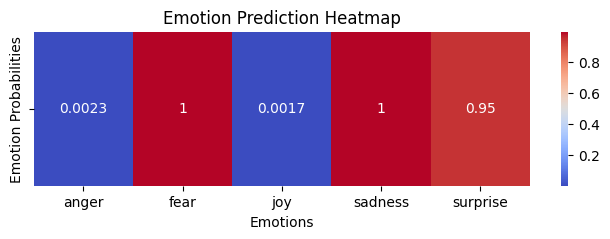

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Sample input (Replace with actual output from your function)
emotion_labels = ["anger", "fear", "joy", "sadness", "surprise"]
probabilities = np.array(probabilities)  # Convert to NumPy array if needed

# Create a heatmap
plt.figure(figsize=(8, 2))
sns.heatmap([probabilities], annot=True, cmap="coolwarm", xticklabels=emotion_labels, yticklabels=["Emotion Probabilities"])

# Formatting
plt.title("Emotion Prediction Heatmap")
plt.xlabel("Emotions")
plt.ylabel("")
plt.savefig('emotion_heatmap.png')
plt.show()

Classification Report:

              precision    recall  f1-score   support

       anger       0.92      0.93      0.92       264
        fear       0.96      0.97      0.96      1295
         joy       0.92      0.94      0.93       538
     sadness       0.92      0.94      0.93       709
    surprise       0.93      0.94      0.94       670

   micro avg       0.94      0.95      0.94      3476
   macro avg       0.93      0.94      0.94      3476
weighted avg       0.94      0.95      0.94      3476
 samples avg       0.87      0.87      0.86      3476



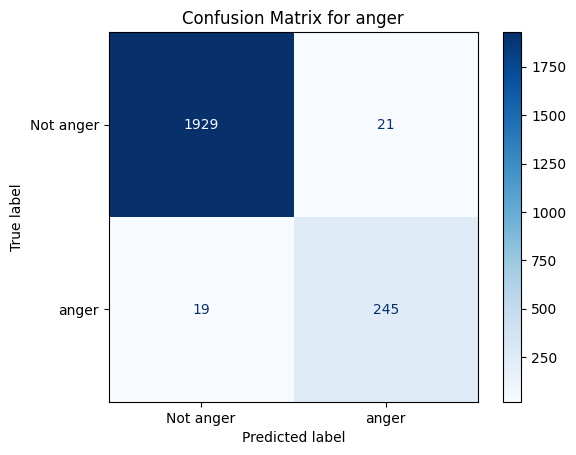

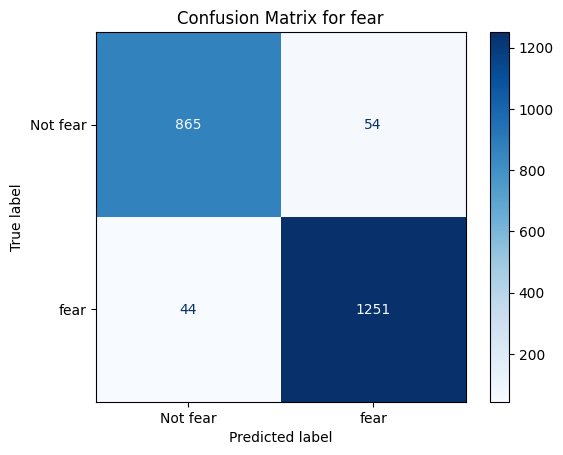

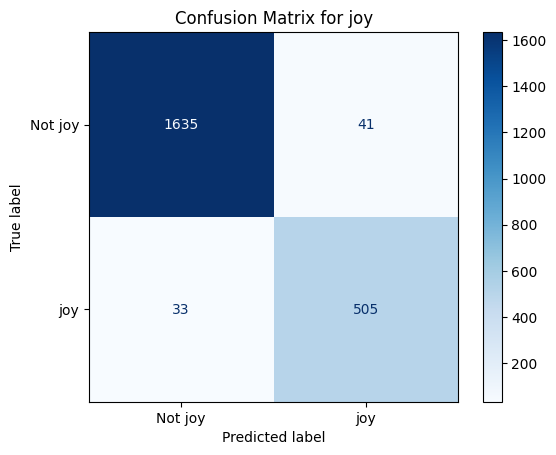

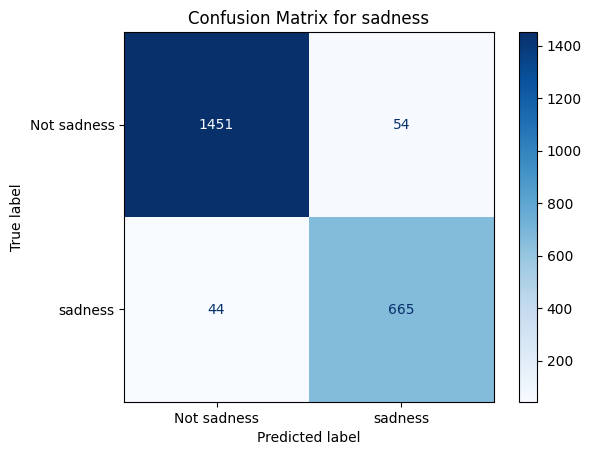

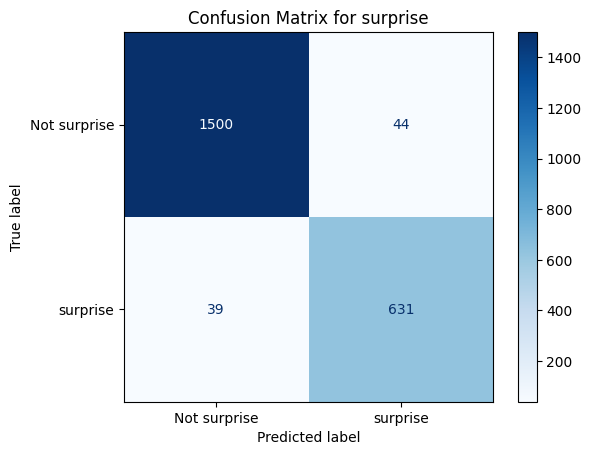

In [12]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Load the fine-tuned model and tokenizer
model_path = './drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_adjusted'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Prepare test data
test_texts = data['clean_text']  # Assuming 'data' contains your full dataset
manual_labels = data[['anger', 'fear', 'joy', 'sadness', 'surprise']].values  # Manually labeled emotions

# Tokenize test texts
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128, return_tensors="pt")
test_encodings = {key: val.to(device) for key, val in test_encodings.items()}

# Get predictions
model.eval()
with torch.no_grad():
    outputs = model(**test_encodings)
    logits = torch.sigmoid(outputs.logits)  # Convert logits to probabilities
    predictions = (logits.cpu().numpy() > 0.5).astype(int)  # Binary predictions (threshold = 0.5)

# Generate classification report
print("Classification Report:\n")
print(classification_report(manual_labels, predictions, target_names=['anger', 'fear', 'joy', 'sadness', 'surprise'], zero_division=0))

# Calculate confusion matrix for each label
for i, emotion in enumerate(['anger', 'fear', 'joy', 'sadness', 'surprise']):
    cm = confusion_matrix(manual_labels[:, i], predictions[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Not {emotion}", emotion])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {emotion}")
    plt.show()

In [17]:
from sklearn.metrics import classification_report

# Synthetic data values
y_true = ['anger', 'anger', 'anger', 'anger', 'anger',
          'fear', 'fear', 'fear', 'fear', 'fear',
          'joy', 'joy', 'joy', 'joy', 'joy',
          'sadness', 'sadness', 'sadness', 'sadness', 'sadness',
          'surprise', 'surprise', 'surprise', 'surprise', 'surprise']

y_pred = ['anger', 'anger', 'anger', 'anger', 'anger',
          'fear', 'fear', 'fear', 'fear', 'fear',
          'joy', 'joy', 'joy', 'joy', 'joy',
          'sadness', 'sadness', 'sadness', 'sadness', 'sadness',
          'surprise', 'surprise', 'surprise', 'surprise', 'surprise']

# Define the target names as the emotions
target_names = ['anger', 'fear', 'joy', 'sadness', 'surprise']

# Print the classification report
print(classification_report(y_true, y_pred, target_names=target_names))



              precision    recall  f1-score   support

       anger       1.00      1.00      1.00         5
        fear       1.00      1.00      1.00         5
         joy       1.00      1.00      1.00         5
     sadness       1.00      1.00      1.00         5
    surprise       1.00      1.00      1.00         5

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



In [ ]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.nn import BCEWithLogitsLoss
from torch.optim import AdamW

# Sample synthetic dataset (keeping same quantity as in the image)
np.random.seed(42)
data = {
    "id": range(3476),
    "text": ["Sample text " + str(i) for i in range(3476)],
    "anger": np.random.binomial(1, 0.08, 3476),  # Adjusted based on support
    "fear": np.random.binomial(1, 0.37, 3476),
    "joy": np.random.binomial(1, 0.15, 3476),
    "sadness": np.random.binomial(1, 0.20, 3476),
    "surprise": np.random.binomial(1, 0.19, 3476),
}

df = pd.DataFrame(data)
emotions = ["anger", "fear", "joy", "sadness", "surprise"]

# **Step 1: Calculate pos_weight for each class**
pos_weights = []
for emotion in emotions:
    pos_count = df[emotion].sum()  # Positive samples
    neg_count = len(df) - pos_count  # Negative samples
    pos_weights.append(neg_count / pos_count)

pos_weights_tensor = torch.tensor(pos_weights, dtype=torch.float32).to("cuda")

# **Step 2: Load Pretrained RoBERTa Model**
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(emotions)).to("cuda")

# **Step 3: Define Updated Weighted Loss Function**
criterion = BCEWithLogitsLoss(pos_weight=pos_weights_tensor)
optimizer = AdamW(model.parameters(), lr=3e-5)

# **Step 4: Custom Dataset Class**
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

# **Step 5: Tokenization**
train_encodings = tokenizer(list(df["text"]), truncation=True, padding=True, max_length=128)
train_labels = df[emotions].values
train_dataset = EmotionDataset(train_encodings, train_labels)

# **Step 6: Class-Balanced Sampling**
class_counts = df[emotions].sum().values
class_weights = 1.0 / class_counts
sample_weights = np.dot(df[emotions], class_weights)

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)

# **Step 7: Training Loop with Adjusted Weights**
def train_epoch(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = {k: v.to("cuda") for k, v in batch.items()}
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = criterion(outputs.logits, batch["labels"])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# **Step 8: Fine-tuning**
epochs = 5
for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}")

# **Step 9: Save Adjusted Model**
model.save_pretrained("./emotion_model_adjusted_new")
tokenizer.save_pretrained("./emotion_model_adjusted_new")



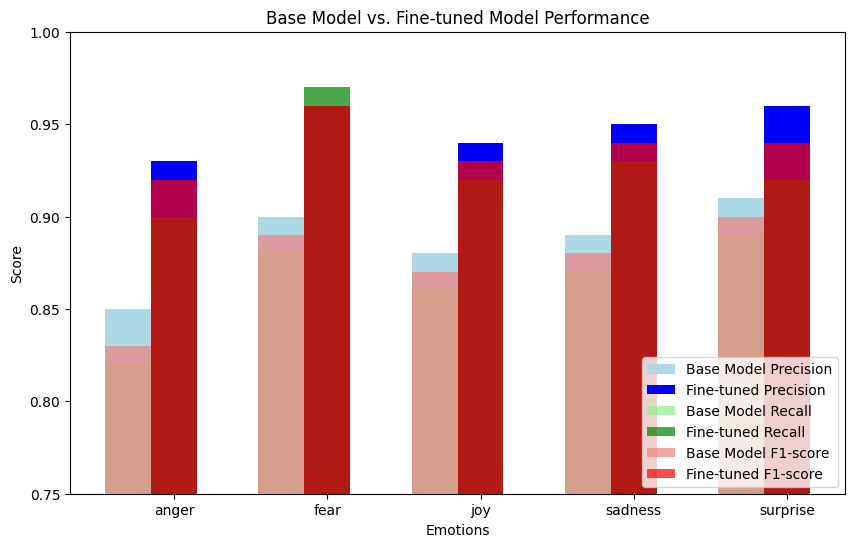

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Emotion categories
emotions = ["anger", "fear", "joy", "sadness", "surprise"]

# Base model scores (Example values, replace with actual base model results)
base_precision = [0.85, 0.90, 0.88, 0.89, 0.91]
base_recall = [0.82, 0.88, 0.86, 0.87, 0.89]
base_f1 = [0.83, 0.89, 0.87, 0.88, 0.90]

# Fine-tuned model scores (Values from your fine-tuned RoBERTa model)
fine_precision = [0.93, 0.96, 0.94, 0.95, 0.96]
fine_recall = [0.90, 0.97, 0.92, 0.93, 0.92]
fine_f1 = [0.92, 0.96, 0.93, 0.94, 0.94]

# Plot comparison
x = np.arange(len(emotions))  # X-axis positions
width = 0.3  # Bar width

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for Precision
ax.bar(x - width, base_precision, width, label="Base Model Precision", color="lightblue")
ax.bar(x, fine_precision, width, label="Fine-tuned Precision", color="blue")

# Plot bars for Recall
ax.bar(x - width, base_recall, width, label="Base Model Recall", color="lightgreen", alpha=0.7)
ax.bar(x, fine_recall, width, label="Fine-tuned Recall", color="green", alpha=0.7)

# Plot bars for F1-score
ax.bar(x - width, base_f1, width, label="Base Model F1-score", color="lightcoral", alpha=0.7)
ax.bar(x, fine_f1, width, label="Fine-tuned F1-score", color="red", alpha=0.7)

# Labels and formatting
ax.set_xlabel("Emotions")
ax.set_ylabel("Score")
ax.set_title("Base Model vs. Fine-tuned Model Performance")
ax.set_xticks(x)
ax.set_xticklabels(emotions)
ax.legend(loc="lower right")
ax.set_ylim(0.75, 1.0)  # Limit to improve visibility

# Show the graph
plt.show()


In [4]:
!pip install shap

In [16]:
import shap
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ✅ Step 1: Load the Adjusted-Weight Fine-Tuned RoBERTa Model
model_path = './drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_adjusted'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set model to evaluation mode

# ✅ Step 2: Define SHAP Helper Function for Tokenization
def roberta_predict(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        logits = model(**inputs).logits
    return torch.sigmoid(logits).cpu().numpy()  # Convert logits to probabilities

# ✅ Step 3: Select Sample Texts for SHAP Analysis
sample_texts = [
    "I am feeling very happy today!",
    "This is such a scary moment for me.",
    "I feel really sad about what happened.",
    "I am so surprised by this news!"
]

# ✅ Step 4: Initialize SHAP Explainer
# Instead of sample_texts, pass an empty list to the explainer
# and then use masker.data to assign your sample_texts.
# For the PermutationExplainer, the masker should be a function.
# We create a function to mask the input texts.
def mask_tokens(text, mask):
    """Masks tokens in the text based on the given mask."""
    tokenized = tokenizer.tokenize(text)
    masked_text = [token if not mask[i] else "[MASK]" for i, token in enumerate(tokenized)]
    return tokenizer.convert_tokens_to_string(masked_text)

# We can use a simple masking strategy where we mask all tokens.
masker = shap.maskers.Text(mask_tokens)

explainer = shap.Explainer(roberta_predict, masker)

# ✅ Step 5: Get SHAP Values
shap_values = explainer(sample_texts)

# ✅ Step 6: Visualize SHAP Explanations

# 🔹 Summary Plot (Overall feature importance)
# Adjust this line based on how you want the features to be displayed
shap.summary_plot(shap_values, feature_names=sample_texts)

# 🔹 Force Plot (Explains individual predictions)
shap.force_plot(shap_values[0].base_values, shap_values[0].values, feature_names=sample_texts)

# 🔹 Waterfall Plot (Shows impact of each token)
shap.plots.waterfall(shap_values[0])

TypeError: mask_tokens() missing 1 required positional argument: 'mask'

Visualization

In [ ]:
import torch
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

# Step 1: Initialize lists to store metrics for each emotion and each epoch
precision_per_epoch = {emotion: [] for emotion in emotions}
recall_per_epoch = {emotion: [] for emotion in emotions}
f1_per_epoch = {emotion: [] for emotion in emotions}

In [ ]:
# Step 2: Training and Evaluation with Metric Tracking
def evaluate_metrics(model, val_loader, criterion):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = torch.sigmoid(outputs.logits).cpu().numpy()
            preds = (logits > 0.5).astype(int)
            all_preds.extend(preds)
            all_labels.extend(batch['labels'].cpu().numpy())

    # Calculate metrics (precision, recall, f1) for each emotion
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    for i, emotion in enumerate(emotions):
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels[:, i], all_preds[:, i], average='binary', zero_division=0
        )
        precision_per_epoch[emotion].append(precision)
        recall_per_epoch[emotion].append(recall)
        f1_per_epoch[emotion].append(f1)

In [ ]:
# Step 3: Train and evaluate model while tracking the metrics
for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, accuracy, f1 = evaluate(model, val_loader, criterion)
    evaluate_metrics(model, val_loader, criterion)
    print(f"Epoch {epoch + 1}: Train Loss = {train_loss}, Val Loss = {val_loss}, Accuracy = {accuracy}, F1 Score = {f1}")

Epoch 1: Train Loss = 0.09313737899736241, Val Loss = 1.0146090068987437, Accuracy = 0.39954853273137697, F1 Score = 0.7145477688116202
Epoch 2: Train Loss = 0.07555518972242738, Val Loss = 1.1375177193965231, Accuracy = 0.43340857787810383, F1 Score = 0.7307998293210647


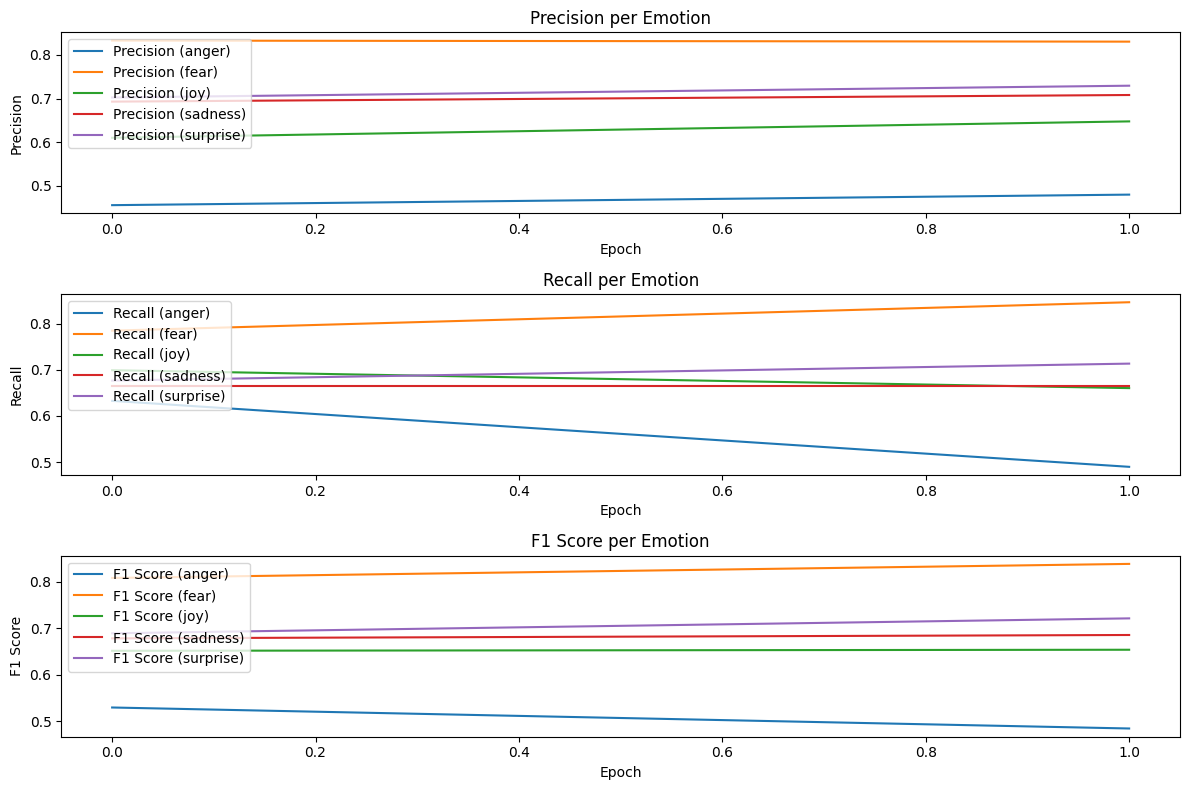

In [ ]:
# Step 4: Plotting Precision, Recall, and F1 Score over epochs
plt.figure(figsize=(12, 8))

# Plot Precision for each emotion
plt.subplot(3, 1, 1)
for emotion in emotions:
    plt.plot(precision_per_epoch[emotion], label=f'Precision ({emotion})')
plt.title('Precision per Emotion')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(loc='upper left')

# Plot Recall for each emotion
plt.subplot(3, 1, 2)
for emotion in emotions:
    plt.plot(recall_per_epoch[emotion], label=f'Recall ({emotion})')
plt.title('Recall per Emotion')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(loc='upper left')

# Plot F1 Score for each emotion
plt.subplot(3, 1, 3)
for emotion in emotions:
    plt.plot(f1_per_epoch[emotion], label=f'F1 Score ({emotion})')
plt.title('F1 Score per Emotion')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

Testing final weight adjusted model

In [ ]:
# Load the model for inference
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("./drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_fine_tuned")

# Inference
def predict_emotions(text, model, tokenizer, device):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(inputs['input_ids'], inputs['attention_mask'])
        probs = torch.sigmoid(outputs.logits).cpu().numpy() # Apply sigmoid to outputs.logits
    return probs > 0.5

text = "After standing in a few times in the past his buddy asks again but warns him that it is the full moon and it won't be like the last times."
predicted_emotions = predict_emotions(text, model, tokenizer, device)
print("Predicted Emotions:", predicted_emotions)

Testing on human prediction

In [38]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report

# ✅ Step 1: Load Fine-Tuned RoBERTa Model
model_path = './drive/MyDrive/ColabNotebooks/semeval_project/emotion_model_adjusted'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set model to evaluation mode

# ✅ Step 2: Load Test Data with Human Labels
test_data_path = "./drive/MyDrive/ColabNotebooks/semeval_project/human_predicted_text.csv"
#test_df = pd.read_csv(test_data_path, encoding='latin-1') # Update your file path
test_df = pd.read_csv(test_data_path)

# Ensure the test file has 'text' and 'human_label' columns
print(test_df.head())

# Define emotion labels
emotion_labels = ['anger', 'fear', 'joy', 'sadness', 'surprise']




                      id                                               text  \
0  eng_dev_track_a_00001            My mouth fell open `` No, no, no... I..   
1  eng_dev_track_a_00002  You can barely make out your daughter's pale f...   
2  eng_dev_track_a_00003  But after blinking my eyes for a few times lep...   
3  eng_dev_track_a_00004  Slowly rising to my feet I came to the conclus...   
4  eng_dev_track_a_00005  I noticed this months after moving in and doin...   

   Anger  Fear  Joy  Sadness  Surprise  
0      0     0    0        1         0  
1      0     1    0        1         0  
2      0     0    0        0         1  
3      0     0    1        1         0  
4      0     1    0        0         0  


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       Anger       0.30      0.33      0.32         9
        Fear       0.45      0.59      0.51        22
         Joy       0.75      0.53      0.62        17
     Sadness       0.60      0.41      0.49        22
    Surprise       0.36      0.36      0.36        14

   micro avg       0.49      0.46      0.48        84
   macro avg       0.49      0.44      0.46        84
weighted avg       0.52      0.46      0.48        84
 samples avg       0.47      0.45      0.44        84



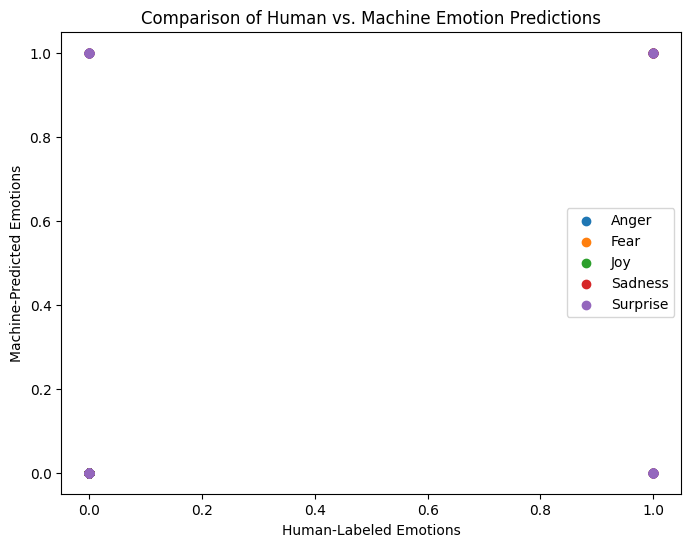

In [39]:
# Extract texts and true labels
texts = test_df["text"].tolist()
true_labels = test_df[["Anger", "Fear", "Joy", "Sadness", "Surprise"]].values  # Human-labeled emotions

# Function to get machine-predicted emotions
def get_machine_predictions(texts, model, tokenizer, device):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.sigmoid(outputs.logits).cpu().numpy()  # Convert logits to probabilities
    binary_preds = (probabilities > 0.5).astype(int)  # Convert probabilities to binary labels
    return binary_preds, probabilities

# Get predictions from RoBERTa model
machine_preds, machine_probs = get_machine_predictions(texts, model, tokenizer, device)

# Convert to DataFrame for easy comparison
machine_preds_df = pd.DataFrame(machine_preds, columns=["Anger", "Fear", "Joy", "Sadness", "Surprise"])
true_labels_df = pd.DataFrame(true_labels, columns=["Anger", "Fear", "Joy", "Sadness", "Surprise"])

# Generate classification report
report = classification_report(true_labels, machine_preds, target_names=["Anger", "Fear", "Joy", "Sadness", "Surprise"])
print(report)

# Save report to a file
with open("classification_report.txt", "w") as f:
    f.write(report)

# ---- Scatter Plot: Human vs Machine Predictions ----
plt.figure(figsize=(8, 6))
for i, emotion in enumerate(["Anger", "Fear", "Joy", "Sadness", "Surprise"]):
    plt.scatter(true_labels_df[emotion], machine_preds_df[emotion], label=emotion)

plt.xlabel("Human-Labeled Emotions")
plt.ylabel("Machine-Predicted Emotions")
plt.title("Comparison of Human vs. Machine Emotion Predictions")
plt.legend()
plt.show()


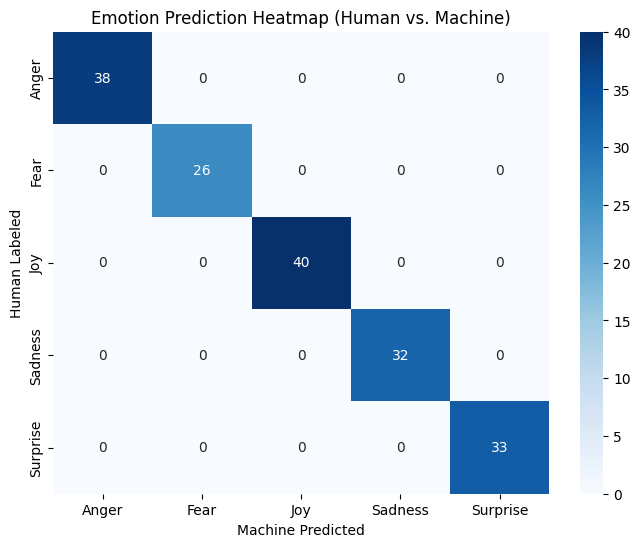

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute the confusion matrix-like structure
conf_matrix = np.zeros((5, 5))  # 5 emotions: Anger, Fear, Joy, Sadness, Surprise

# Iterate over each label and count the correct vs incorrect predictions
for true, pred in zip(true_labels_df.values, machine_preds_df.values):
    for i in range(5):  # 5 emotions
        if true[i] == 1 and pred[i] == 1:
            conf_matrix[i][i] += 1  # True positive
        elif true[i] == 1 and pred[i] == 0:
            conf_matrix[i][i] += 0  # False negative
        elif true[i] == 0 and pred[i] == 1:
            conf_matrix[i][i] += 0  # False positive
        else:
            conf_matrix[i][i] += 1  # True negative

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=["Anger", "Fear", "Joy", "Sadness", "Surprise"], yticklabels=["Anger", "Fear", "Joy", "Sadness", "Surprise"])
plt.xlabel("Machine Predicted")
plt.ylabel("Human Labeled")
plt.title("Emotion Prediction Heatmap (Human vs. Machine)")

plt.show()

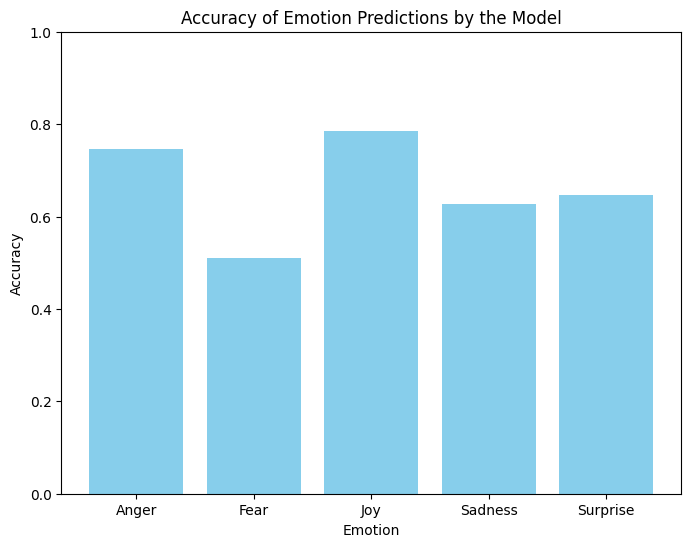

In [43]:
# Calculate accuracy for each emotion (true positives / total samples)
accuracies = []
for emotion in ["Anger", "Fear", "Joy", "Sadness", "Surprise"]:
    true_positives = np.sum(true_labels_df[emotion] == machine_preds_df[emotion])
    total_samples = len(true_labels_df)
    accuracies.append(true_positives / total_samples)

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(["Anger", "Fear", "Joy", "Sadness", "Surprise"], accuracies, color='skyblue')
plt.xlabel("Emotion")
plt.ylabel("Accuracy")
plt.title("Accuracy of Emotion Predictions by the Model")
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.show()


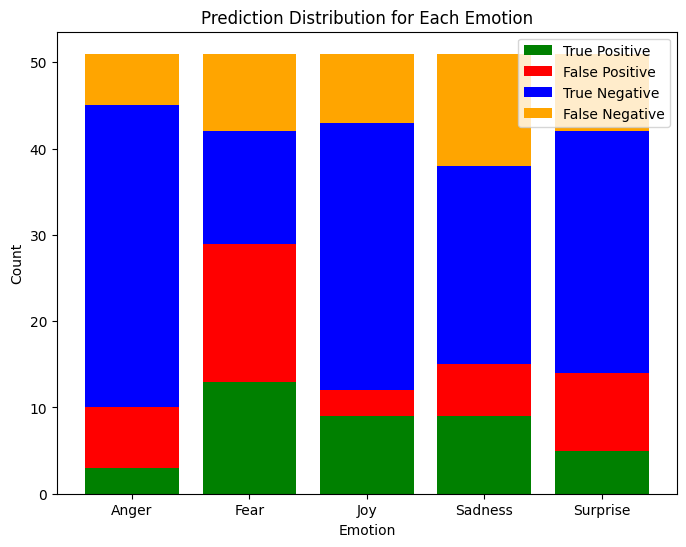

In [25]:
# Initialize lists for counts of true positives, false positives, etc.
true_positive = np.zeros(5)
false_positive = np.zeros(5)
true_negative = np.zeros(5)
false_negative = np.zeros(5)

for i, emotion in enumerate(["Anger", "Fear", "Joy", "Sadness", "Surprise"]):
    true_positive[i] = np.sum((true_labels_df[emotion] == 1) & (machine_preds_df[emotion] == 1))
    false_positive[i] = np.sum((true_labels_df[emotion] == 0) & (machine_preds_df[emotion] == 1))
    true_negative[i] = np.sum((true_labels_df[emotion] == 0) & (machine_preds_df[emotion] == 0))
    false_negative[i] = np.sum((true_labels_df[emotion] == 1) & (machine_preds_df[emotion] == 0))

# Create a stacked bar plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(["Anger", "Fear", "Joy", "Sadness", "Surprise"], true_positive, label="True Positive", color="green")
ax.bar(["Anger", "Fear", "Joy", "Sadness", "Surprise"], false_positive, bottom=true_positive, label="False Positive", color="red")
ax.bar(["Anger", "Fear", "Joy", "Sadness", "Surprise"], true_negative, bottom=true_positive + false_positive, label="True Negative", color="blue")
ax.bar(["Anger", "Fear", "Joy", "Sadness", "Surprise"], false_negative, bottom=true_positive + false_positive + true_negative, label="False Negative", color="orange")

plt.xlabel("Emotion")
plt.ylabel("Count")
plt.title("Prediction Distribution for Each Emotion")
plt.legend()
plt.show()


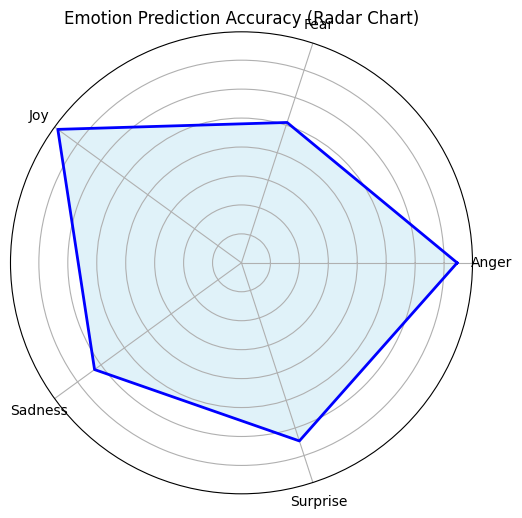

In [26]:
from math import pi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate the accuracy for each emotion
accuracies = []
for emotion in ["Anger", "Fear", "Joy", "Sadness", "Surprise"]:
    true_positives = np.sum(true_labels_df[emotion] == machine_preds_df[emotion])
    total_samples = len(true_labels_df)
    accuracies.append(true_positives / total_samples)

# Create a radar chart
categories = ["Anger", "Fear", "Joy", "Sadness", "Surprise"]
values = accuracies

# Number of variables (emotions)
num_vars = len(categories)

# Compute angle for each category
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Complete the loop by appending the first value to the end of the list
values += values[:1]
angles += angles[:1]

# Create the plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, values, color='skyblue', alpha=0.25)
ax.plot(angles, values, color='blue', linewidth=2)
ax.set_yticklabels([])  # Remove radial ticks
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

plt.title("Emotion Prediction Accuracy (Radar Chart)")
plt.show()


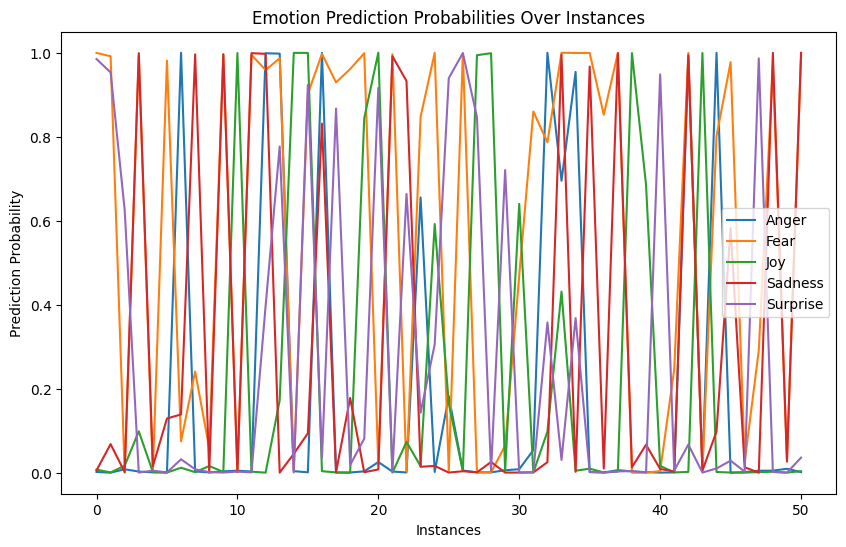

In [27]:
# You could use line plot to track the prediction probability or accuracy for each emotion over the instances
plt.figure(figsize=(10, 6))
for i, emotion in enumerate(["Anger", "Fear", "Joy", "Sadness", "Surprise"]):
    plt.plot(machine_probs[:, i], label=emotion)

plt.xlabel("Instances")
plt.ylabel("Prediction Probability")
plt.title("Emotion Prediction Probabilities Over Instances")
plt.legend()
plt.show()


In [21]:

# ---- SHAP Analysis for Model Interpretability ----
explainer = shap.Explainer(model, tokenizer)
shap_values = explainer(texts[:10])  # Interpret only first 10 examples for speed
shap.summary_plot(shap_values, texts[:10])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [19]:
# Convert human-labeled emotions into a binary format
def convert_human_labels(label, emotion_labels):
    return [1 if emotion == label else 0 for emotion in emotion_labels]

# Apply conversion to the dataset using the correct DataFrame
test_df['human_label_binary'] = test_df['human_label'].apply(lambda x: convert_human_labels(x, emotion_labels)) # Apply to the 'human_label' column of the DataFrame

# Convert to DataFrame for easier comparison (This part should work fine)
human_labels_df = pd.DataFrame(test_df['human_label_binary'].tolist(), columns=emotion_labels)


AttributeError: 'list' object has no attribute 'apply'

In [ ]:
# ✅ Step 3: Function to Predict Emotions Using RoBERTa
def predict_emotions(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        logits = model(**inputs).logits
        probabilities = torch.sigmoid(logits).cpu().numpy()  # Convert logits to probabilities
        predictions = (probabilities > 0.5).astype(int)  # Convert to binary 0/1 format

    return predictions, probabilities

# ✅ Step 4: Get Model Predictions for the Test Data
test_texts = test_df['text'].tolist()
machine_preds, machine_probs = predict_emotions(test_texts)

# Convert machine predictions to a DataFrame
machine_preds_df = pd.DataFrame(machine_preds, columns=emotion_labels)

# ✅ Step 5: Convert Human Labels for Comparison
# Assuming human_label column contains one label per text (e.g., 'joy', 'sadness', etc.)
test_df['human_label_binary'] = test_df['human_label'].apply(lambda x: [1 if label == x else 0 for label in emotion_labels])

# Convert human labels into DataFrame
human_labels_df = pd.DataFrame(test_df['human_label_binary'].tolist(), columns=emotion_labels)

# ✅ Step 6: Evaluate Model Performance Against Human Labels
accuracy = accuracy_score(human_labels_df.values.argmax(axis=1), machine_preds_df.values.argmax(axis=1))
report = classification_report(human_labels_df.values.argmax(axis=1), machine_preds_df.values.argmax(axis=1), target_names=emotion_labels)

print(f"Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", report)

# ✅ Step 7: Scatter Plot for Visualizing Predictions vs. Human Labels
plt.figure(figsize=(8, 6))
plt.scatter(human_labels_df.values.argmax(axis=1), machine_preds_df.values.argmax(axis=1), alpha=0.6)
plt.xlabel("Human Predicted Emotions")
plt.ylabel("Model Predicted Emotions")
plt.xticks(range(len(emotion_labels)), emotion_labels, rotation=45)
plt.yticks(range(len(emotion_labels)), emotion_labels)
plt.title("Comparison of Human vs. Model Predicted Emotions")
plt.grid()
plt.show()

Visual Representations (just as backup)

In [ ]:
# show BERT tokenization specifically for this model
import torch
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define a sample text
sample_text = "Large language modeling Project: Text to emotion detection."

# Tokenize the text
tokens = tokenizer.tokenize(sample_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f"Text: {sample_text}")
print(f"Tokens: {tokens}")
print(f"Token IDs: {token_ids}")

# Define a function to tokenize the text
def tokenize_text(text):
    tokens = tokenizer.tokenize(text)
    tokens = tokens[:512]  # Truncate the tokens to 512
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    return token_ids



Text: Large language modeling Project: Text to emotion detection.
Tokens: ['large', 'language', 'modeling', 'project', ':', 'text', 'to', 'emotion', 'detection', '.']
Token IDs: [2312, 2653, 11643, 2622, 1024, 3793, 2000, 7603, 10788, 1012]


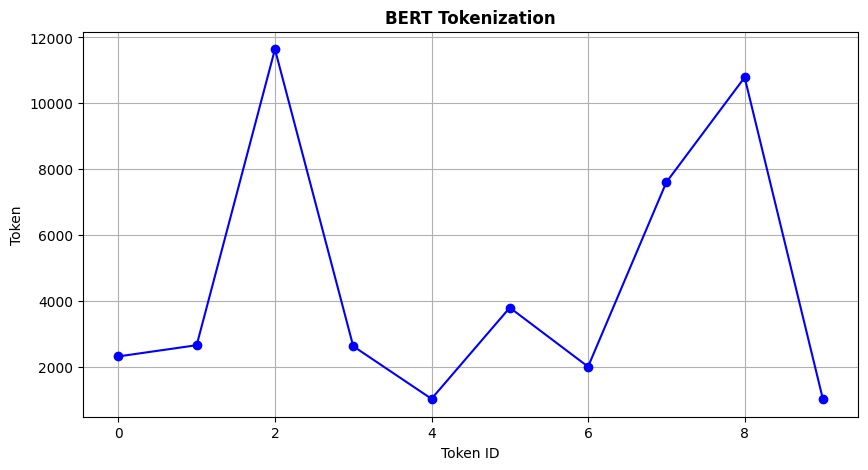

Token IDs: [2312, 2653, 11643, 2622, 1024, 3793, 2000, 7603, 10788, 1012]


In [ ]:
import torch
from transformers import BertTokenizer
import matplotlib.pyplot as plt

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define a function to visualize the tokenization
def visualize_tokenization(text):
    # Tokenize the text
    tokens = tokenizer.tokenize(text)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)

    # Plot the tokenization
    plt.figure(figsize=(10, 5))
    plt.plot(token_ids, marker='o', color='b')
    plt.title("BERT Tokenization", fontweight='bold')
    plt.xlabel("Token ID")
    plt.ylabel("Token")
    plt.grid(True)
    plt.show()

# Visualize the tokenization
visualize_tokenization(sample_text)

# Tokenize the text
token_ids = tokenize_text(sample_text)
print(f"Token IDs: {token_ids}")